# Sentiment Analysis on the London AirBnB Data
## Module 3b

# 1. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk

!pip install langdetect
from langdetect import detect  # pip install langdetect

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser

import seaborn as sns
!pip install shapely
import shapely # pip install shapely
from shapely.geometry import Point
!pip install geopandas
import geopandas as gpd # pip install geopandas

import warnings
warnings.filterwarnings("ignore")
!pip install wordcloud
from wordcloud import WordCloud # pip install wordcloud

from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
!pip install yellowbrick
from yellowbrick.text.freqdist import FreqDistVisualizer # pip install yellowbrick
from yellowbrick.style import set_palette

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fabrizio/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
%matplotlib inline

# 2. Data Gathering

In [3]:
# reviews and neighbourhoods datasets
reviews = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2021-12-07/data/reviews.csv.gz")
neighbourhoods = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2021-12-07/visualisations/neighbourhoods.csv")

In [4]:
# shape file of London Neighbourhoods (map)
london_neighbourhoods = gpd.read_file('https://fabriziorocco.it/fabrizio.zip')

In [5]:
# listings dataset 
listings = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2021-12-07/data/listings.csv.gz")
listings = listings[["id", "description", "host_id", "host_name", "neighbourhood_cleansed", "latitude", "longitude",
                    "property_type", "room_type", "review_scores_rating", "host_response_time",
                    "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_neighbourhood", 
                    "host_verifications", "host_has_profile_pic", "host_identity_verified", "accommodates", 
                    "bathrooms_text", "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights",
                    "availability_30", "number_of_reviews", "review_scores_cleanliness", "review_scores_accuracy",
                    "review_scores_checkin", "review_scores_communication", "review_scores_location",
                    "review_scores_value", "reviews_per_month"]]

## 2.1 URLs

**AirBnB Data:**
http://insideairbnb.com/get-the-data.html (London)


**Geospatial Data London Neighbourhoods:**
https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

# 3. Data inspection and preprocessing

## 3.1 Initial inspection

In [ ]:
reviews.head(3)

In [ ]:
listings.head(3)

## 3.2 Detecting missing values and systematically unuseful comments

In [ ]:
## check NA comments in reviews dataframe
reviews.isnull().sum() 

In [6]:
## check out whether there are prototypical cancellation comments, these are of no value for the analysis
reviews['comments'].str.match('The host canceled this reservation').sum()

14375

## 3.3 Data Preprocessing: Dropping NAs, dropping cancellation comments, remove dashes and numeric, remove escape characters, replace multi tab by tab, remove "." comments

NOTE: In this preprocessing we will keep capitalizations and punctuation, even though this is typically part of the text normalization step in the NLP pipeline. This is due to the fact that VADER (Valence Aware Dictionary and Sentiment Reasoner), which is the sentiment analysis tool that will be used later on, works much better when capaitalization and punctuation are kept in (VADER adds valence to capitalized words, or words that are accompanied by punctuation or emoticons).

In [7]:
reviews.dropna(subset =['comments'], how='any', axis=0, inplace=True)             # drop NA comments

index_canceled = reviews[reviews['comments'].str.match('The host canceled this reservation')].index
reviews.drop(index_canceled, inplace=True)                                        # drop cancellation comments

index_dash = reviews[reviews['comments'].str.match('-')].index                    # remove dashes
reviews.drop(index_dash, inplace=True)

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
reviews['comments'] = reviews['comments'].map(alphanumeric)                       # remove numeric 

reviews['comments'] = reviews['comments'].str.replace('\r\n',"")                  # remove windows new line

reviews['comments'] = reviews['comments'].str.replace('\r<br/>',"")               # remove html new line
reviews['comments'] = reviews['comments'].str.replace('\r<br>',"")                # remove html new line
reviews['comments'] = reviews['comments'].str.replace('\r</br>',"")               # remove html new line
reviews['comments'] = reviews['comments'].str.replace('\.<br/>',"")               # remove html new line

reviews['comments'] = reviews['comments'].str.replace('\s+', ' ')                 # replace x spaces by one space

reviews = reviews[reviews.comments != "."]                                        # remove "." comments

reviews.reset_index(inplace=True, drop=True)                                      # reset index after manipulations

## 3.4 Data Preprocessing: Detecting Languages

In an international AirBnB location such as London it is common that some reviews are non-English. We will thus look at the occurence and frequency of other languages using the langdetect library in order to decide how to handle these comments. 

### 3.4.1 Check for errors thrown by the langdetect function

To make sure the detect function runs smoothly and to determine whether its language categorization output is appropriate, we first look at any errors it might throw. NOTE: The below function has substantial compute time (~ 40 mins).

In [ ]:
num_errors = 0
err = []
for index, row in reviews.iterrows():
    try:
        language = detect(row['comments']) #(" ".join(row.split())) # row.strip())
    except:
        num_errors += 1
        err.append(index)
        print("This row throws an error:", row['comments'])

When the langdetect function throws an error, it is either because of emojis (e.g. "⭐️") that were used as comments, expressive punctuation that was given as the only comment (e.g. "!!!!!!!!") or other non-interpretable combinations of full stops, brackets and special characters. As such comments are in general very hard to interpret, we will drop these rows from the reviews dataframe.

In [ ]:
# save indexes of the rows where errors were thrown in order to avoid running the above loop again
aux_df = pd.DataFrame()
aux_df["errors"] = err
aux_df.to_csv("errors_language_detect_indexes.csv")

In [10]:
aux_df = pd.read_csv('https://fabriziorocco.it/errors_language_detect_indexes.csv')

In [11]:
# Percentage of comments that threw an error
print('{:.2f}% of entries for language identification throw errors'.format(num_errors/reviews['comments'].shape[0] * 100))

NameError: name 'num_errors' is not defined

In [12]:
# drop the rows that threw errors above, i.e. that have comments which cannot be assigned to a language
reviews.drop(list(aux_df.errors), axis=0, inplace=True)
reviews.reset_index(inplace=True, drop=True)

In [13]:
# and create new col 'language' with detected language
reviews['language'] = reviews['comments'].apply(detect)

In [15]:
reviews.to_csv("reviews_with_lan.csv")

### 3.4.2 Visualize language distribution

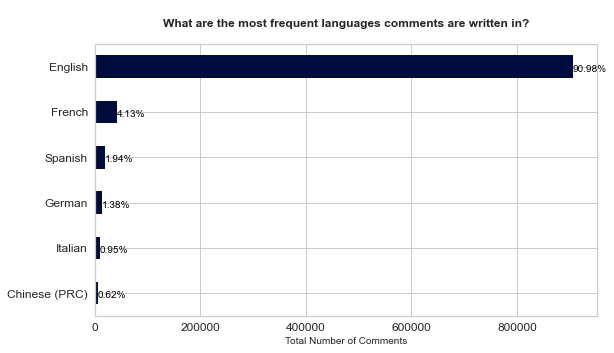

In [16]:
ax = reviews.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="#000B3D", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel("Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'French', 'Spanish', 'German', 'Italian', 'Chinese (PRC)'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

As we can see, the vast majority of comments is in English. We thus decided to focus on these reviews exclusively. We do create a copy of the original datframe with all languages in case it becomes relevant to translate and include the non-English comments as well:

### 3.4.3 Creation of copy of complete dataset in case we eventually want to try translating the non-English rows instead of dropping them

In [17]:
# create copy 
reviews_en = reviews.copy(deep=True)

# isolate all non-English entries
index_nonen = reviews_en[~reviews_en['language'].str.match('en')].index

# drop non-English entries 
reviews_en.drop(index_nonen, inplace=True)

**``reviews_en`` is thus the main "reviews" dataframe we will be working with from here on!**

# 4. Sentiment Analysis

## 4.1 Estimating Polarity with VADER

To analyze the sentiment of comments and extract relevant information from them it is necessary to score how positive or negative they are. This is done by assigning a so called polarity score, which usually ranges from -1 to 1 (negative scores being bad reviews and vice versa). 

To determine polarity scores we used *VADER* (Valence Aware Dictionary and Sentiment Reasoner), which is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. *VADER* uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.

*VADER* has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because *VADER* not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

*VADER* adds valence to words capitalized, with punctuation (e.g. compound score increases with number of exclamation points!), with degree modifiers (e.g. very good vs good), emojis, and handles conjunctions (... but ... -> shifts in sentiment polarity).

### 4.1.1 Downloading the VADER lexicon and initial exploration of the tool

In [18]:
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fabrizio/nltk_data...


In [19]:
reviews_en.comments[0]

"My girlfriend and I hadn't known Alina before we took the leap of faith to rent her flat. Alina just couldn't be nicer! Her flat is comfortable, homey, very sunny, and quiet at night. Her diverse neighborhood rocks! It's full of excellent eateries of varying ethnicities, good supermarkets, etc., etc. Her place is about a -minute walk to the Finsbury Park tube stop, and there are also several buses that ply Stroud Green Road. The Piccadilly and Victoria tube lines that serve Finsbury Park are very dependable and come frequently. My only caveat is if you are unwilling to take - to -minute commutes to downtown London attractions and money is no object, you will prefer to stay downtown. But for anyone else, you will love your experience of living in a real, untouristy neighborhood and dealing with a generous, warm-hearted woman I'm happy to call a new friend."

**This review seems to be quite good.**

In [20]:
# test it out on first comment

def sentiment_analyzer_scores(comment):
    score = analyzer.polarity_scores(comment)
    return(pd.DataFrame.from_dict(score, orient='index'))

sentiment_analyzer_scores(reviews_en['comments'][0])

,0
neg,0.0290
neu,0.7770
pos,0.1940
compound,0.9827


**As expected, VADER assigns a highly positive compound polarity score.**

### 4.1.2 Adding polarity scores to each review in the main dataframe

In [21]:
# we want one overall polarity score, so just look at the 'compound' score
polarity_compound = lambda s: (analyzer.polarity_scores(s))['compound']

# add compound polarity feature to main dataframe
reviews_en['polarity'] = reviews_en.comments.map(polarity_compound)

In [23]:
reviews_en.to_csv("reviews_with_lan_with_polarity.csv")

**Exploring positive polarity score**

In [22]:
reviews_en[:1].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,13913,80770,2010-08-18,177109,Michael,"My girlfriend and I hadn't known Alina before we took the leap of faith to rent her flat. Alina just couldn't be nicer! Her flat is comfortable, homey, very sunny, and quiet at night. Her diverse neighborhood rocks! It's full of excellent eateries of varying ethnicities, good supermarkets, etc., etc. Her place is about a -minute walk to the Finsbury Park tube stop, and there are also several buses that ply Stroud Green Road. The Piccadilly and Victoria tube lines that serve Finsbury Park are very dependable and come frequently. My only caveat is if you are unwilling to take - to -minute commutes to downtown London attractions and money is no object, you will prefer to stay downtown. But for anyone else, you will love your experience of living in a real, untouristy neighborhood and dealing with a generous, warm-hearted woman I'm happy to call a new friend.",en,0.982700


**Exploring negative polarity score**

In [24]:
reviews_en[reviews_en['polarity']<0][3:4].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
1993,43202,87833327,2016-07-22,64968087,Patricia,Unfortunately we could not enjoy our stay at Calypso's apartment as the noise and vibration from the construction site was so bad it caused glasses and crockery to shake in our kitchen. It was also extremely hot during our midweek stay. Calyspo was there to welcome us and responded quickly to questions we had during our stay eg how to get sound on TV. Bus stop is right outside the building.,en,-0.856200


## 4.2 Explore polarity and its correlation with rating features

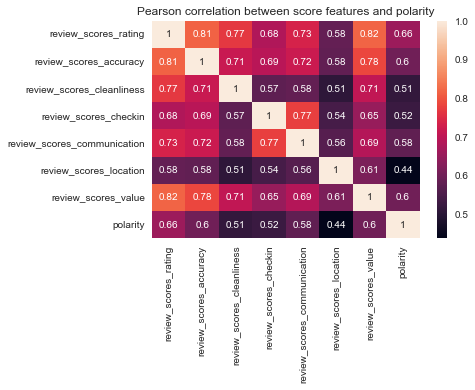

In [25]:
reviews_and_ratings_listings = listings[['id', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                         'review_scores_cleanliness', 'review_scores_checkin', 
                         'review_scores_communication', 'review_scores_location', 'review_scores_value',
                         'neighbourhood_cleansed']]

list_pol = pd.DataFrame(reviews_en.groupby(['listing_id']).mean()['polarity'])

polarity_x_ratings = pd.merge(reviews_and_ratings_listings, list_pol, left_on='id', right_on='listing_id', how='left')

review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'polarity']

corr = polarity_x_ratings[review_scores].corr()

sns.heatmap(corr, annot=True)
plt.title('Pearson correlation between score features and polarity');

**Observations in the correlation matrix:**

Looking at the correlation of the polarity feature with other rating scores, we see that there is a significant positive relationship with all of them. This is to be expected. The highest correlation is observed for the overall rating (``review_scores_rating``). Surprisingly, the lowest correlation exists between ``polarity``and ``review_scores_location``, which would indicate that location does actually not play a large role in terms of guest review their stay in an AirBnB apartment in London. On the other hand, this does make sense to some extent since the location of the apartment is one of the few things that are very clear to a guest when booking, and so it is unlikely that this aspect would cause a particularly good or bad review.

## 4.3 Explore neighbourhoods

Another interesting aspect to look at is the distribution of ratings and polarity scores across different neighbourhoods in London. To shine a light on this we will look at the average location rating score per neighbourhood, the average composite rating score, and finally the average polarity per neighbourhood. 

In [26]:
# shape file of London neighbourhoods (called london_neighbourhoods) was imported above (see 2. Importing data)

# list of London neighbourhoods as they appear in the shape file
borough_list = ["Kingston upon Thames", "Croydon", "Bromley", "Hounslow", "Ealing", "Havering", "Hillingdon",
                "Harrow", "Brent", "Barnet", "Lambeth", "Southwark", "Lewisham", "Greenwich", "Bexley", "Enfield",
                "Waltham Forest", "Redbridge", "Sutton", "Richmond upon Thames", "Merton", "Wandsworth",
                "Hammersmith and Fulham", "Kensington and Chelsea", "Westminster", "Camden", "Tower Hamlets", 
                "Islington", "Hackney", "Haringey", "Newham", "Barking and Dagenham", "City of London"]

# adding neighbourhood identfier to shape file
london_neighbourhoods["Name"] = borough_list

# use dataframe polarity_x_ratings from 4.2 and aggregate to receive means for each neighbourhood
listings_neighb = pd.DataFrame(polarity_x_ratings.groupby(['neighbourhood_cleansed']).mean())
listings_neighb.drop(['id'], axis=1, inplace=True)

# final dataframe to be used for analysis across neighbourhoods of London 
london_neighb = london_neighbourhoods.merge(listings_neighb, left_on='Name', right_on='neighbourhood_cleansed')

### 4.3.1 Average location rating score per neighbourhood

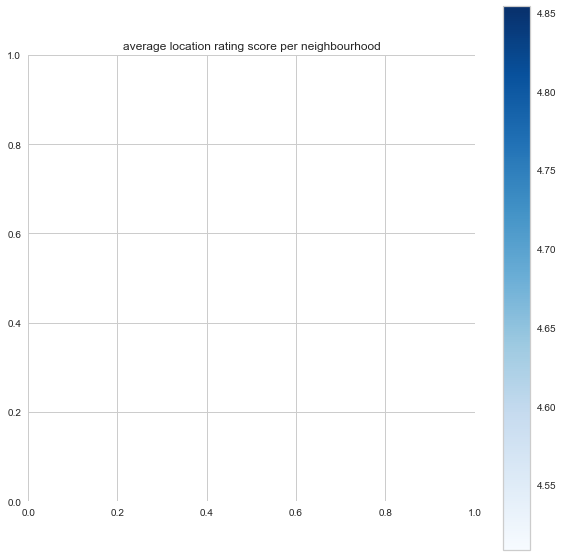

In [27]:
london_neighb.plot(column='review_scores_location', cmap='Blues', figsize=(10,10), legend=True)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('average location rating score per neighbourhood');

### 4.3.2 Average composite rating score per neighbourhood

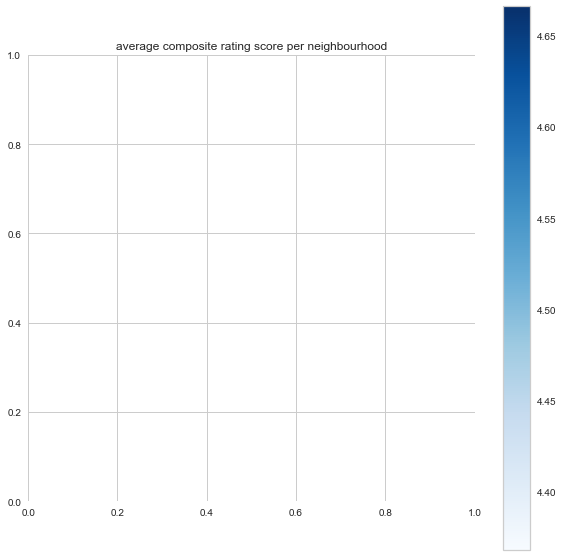

In [28]:
london_neighb.plot(column='review_scores_rating', cmap='Blues', figsize=(10,10), legend=True)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('average composite rating score per neighbourhood');

### 4.3.3 Average polarity score per neighbourhood

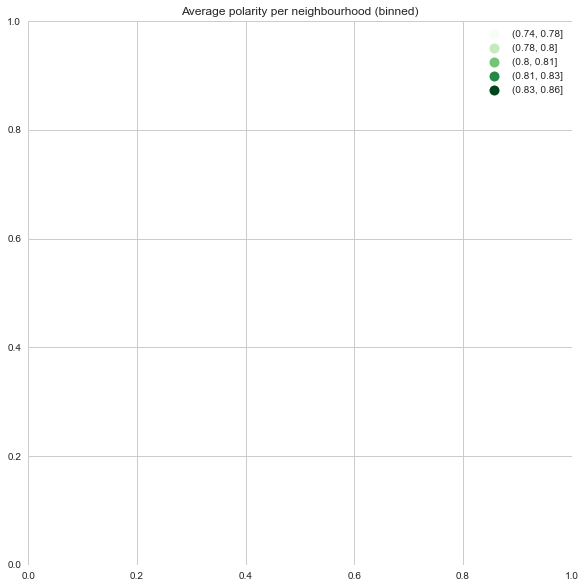

In [29]:
london_neighb['polarity_bin'] = pd.qcut(london_neighb['polarity'], q=5, precision=2)
london_neighb.plot(column='polarity_bin', cmap='Greens', figsize=(10,10), legend=True)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.title('Average polarity per neighbourhood (binned)');

**Observations from exploring the different scores across neighbourhoods:**

Overall very positive reviews on average, location, composite and polarity scores are quite high on average. What is noteworthy is that some neighbourhoods tend to perform clearly better on all metrics. These are on the one hand the very central neighbourhoods such ..., ... and ..., but on the other hand also ... and ... which are located in the South Western part of London. 

## 4.4 Find out what guests like and dislike

Having introduced and analyzed the polarity scores, we will now look deeper into what - according to their reviews - guests truly value when staying in an AirBnB and what they really dislike.

### 4.4.1 Initial exploration of positive vs. negative comments

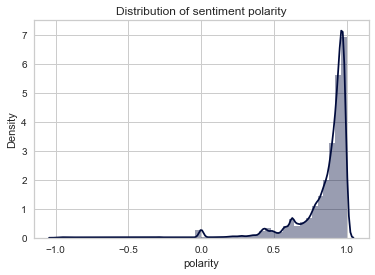

In [30]:
sns.distplot(reviews_en['polarity'], norm_hist=True, color='#000B3D')
plt.title('Distribution of sentiment polarity');

We observe that the vast majority of reviews have high (positive) sentiment scores. This is very common on AirBnB.

**Splitting the data into highly positive and negative comments:**

In [31]:
# full dataframe with POSITIVE comments
reviews_pos = reviews_en.loc[reviews_en.polarity >= 0.95]

# only corpus of POSITIVE comments
pos_comments = reviews_pos['comments'].tolist()

# full dataframe with NEGATIVE comments
reviews_neg = reviews_en.loc[reviews_en.polarity < 0.0]

# only corpus of NEGATIVE comments
neg_comments = reviews_neg['comments'].tolist()

**Looking at some positive and some negative comments to get a feeling:**

In [32]:
# read some positive comments
pos_comments[20:23]

["My parents came to London and needed a place to stay. I booked Philippa's apartment because I loved the position and the pictures on Airbnb. I arrived a day before my parents and went to Philippa to do the check in. She was amazing! So kind! The flat was super clean and tidy and very welcoming. I loved it at first glance!I recommend the flat because has an extraordinary position ( it's in the heart of Chelsea, in Kings road!!!) and Philippa is an amazing host.I definitely will rent again the flat in future!",
 "I enjoyed my stay at Phillipa's apartment. It was within easy walking distance to the underground station and was in an attractive and upmarket part of London. It was a bonus having Waitrose supermarket in the next street. Although I didn't get to meet Phillipa ( she was overseas) I had regular contact with her and she was concerned that I had a pleasant stay and everything I needed. I would recommend the apartment for both a long or short term stay in London. Melanie Brown",


In [33]:
# read some negative comments
neg_comments[20:23]

["I don't like to leave mediocre reviews lightly, but realistically I would not stay here again, nor would I recommend this spot to a friend. First of all, I did have a hard time finding this apartment as the entrance is essentially at the back of the building, secondly there was an issue with picking up keys to the unit. They were left with a mini-mart clerk, and that in itself was awkward (picking up keys at a mini-mart almost feels like a drug deal). Once picking up the keys, we found they were the wrong keys and were missing the entrance fob, so could not enter the building. That was too bad after having traveled hours. Kris did answer his phone and handle the situation, but having that start to a stay is too bad. That makes staying at a hotel much more convenient. Once we finally entered the building, it seems dated and smelled of cigarettes. From the photos, I expected something nicer. The unit was suitable, but the photos are definitely over-flattering. I would not describe the 

### 4.4.2 Investigating Positive Comments

**WordCloud**

After reading some of these reviews and to really discover what visitors applaud or complain about, WordClouds are a great tool to help us peek behind he curtain:

In [34]:
# function to plot wordclouds
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

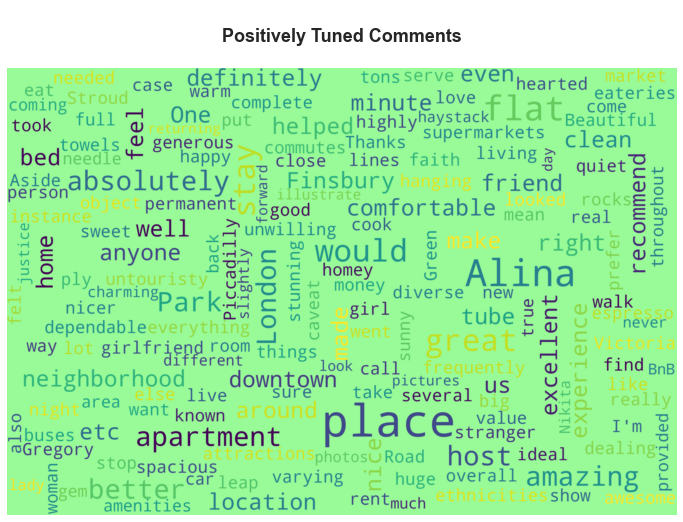

In [38]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="palegreen",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(reviews_pos.comments.values))

plot_wordcloud(wordcloud, '\nPositively Tuned')

**Frequency Distribution**

Another method for visually exploring text is with frequency distributions. In the context of a text corpus, such a distribution tells us the prevalence of certain words. Here we use the Yellowbrick library.

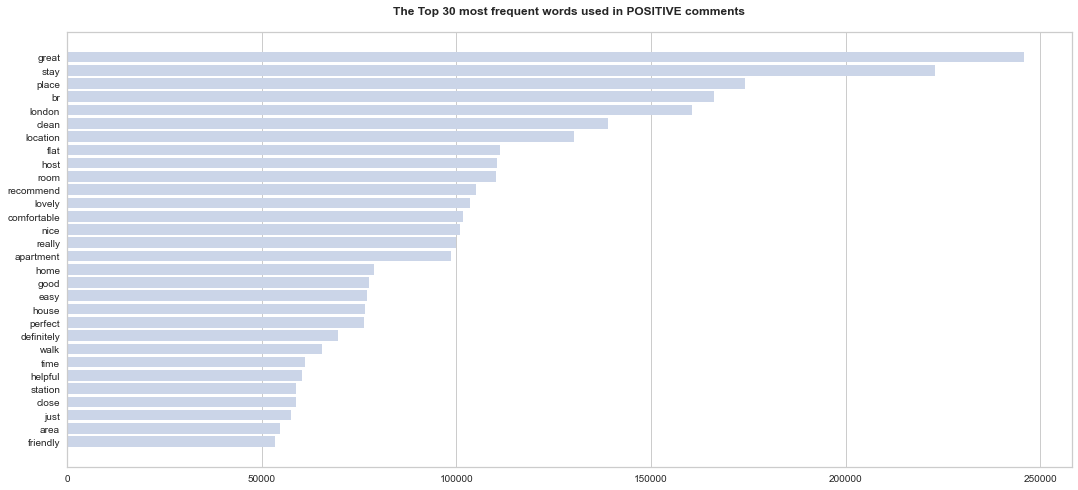

In [39]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(pos_comments)
features = vectorizer.get_feature_names()

# preparing the plot
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

### 4.4.3 Investigating Negative Comments

**Word Cloud**

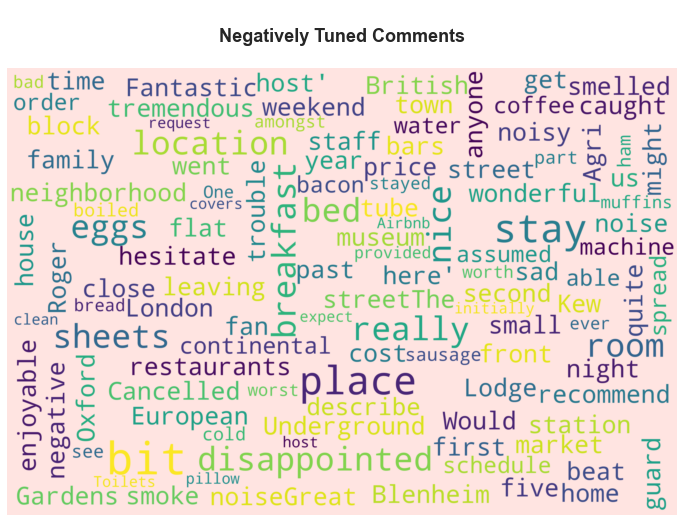

In [40]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="mistyrose",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(reviews_neg.comments.values))

plot_wordcloud(wordcloud, '\nNegatively Tuned')

**Frequency Distribution**

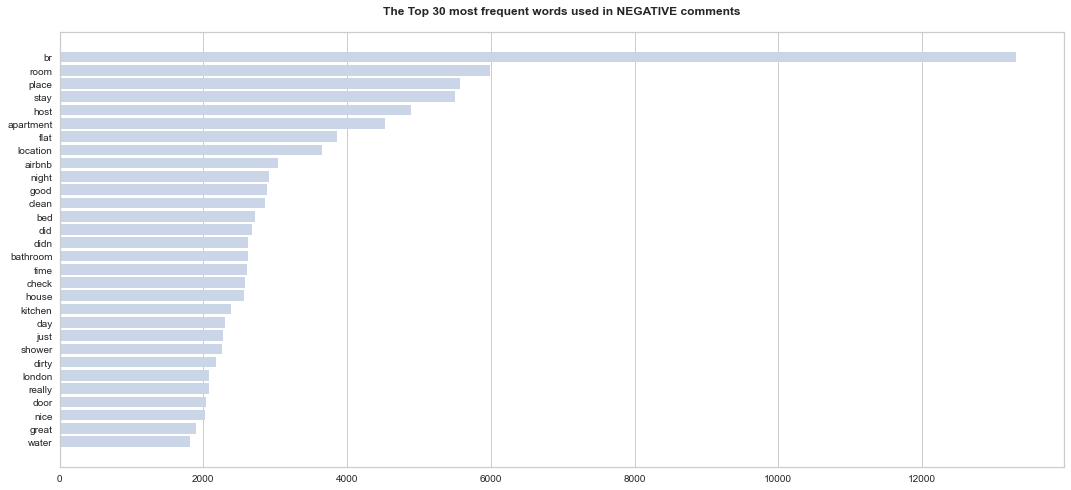

In [41]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(neg_comments)
features = vectorizer.get_feature_names()

# preparing the plot
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in NEGATIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30).fit(docs)
visualizer.poof;

## 4.5 Functions to perform sentiment analysis on neighbourhood level

By creating these functions, the main functionality of our application with regard to the aspect of sentiment analysis is enabled. With the help of these functions and the information they provide, the users of our application (i.e. AirBnB hosts) can get an idea regarding imoportant aspects that customers value in the neighbourhood of the host's property.

### 4.5.1 Enriching ``reviews_en`` with neighbourhood data and then subsetting data into positive and negative comments again

In [43]:
listings_only_neighbourhood = listings[["neighbourhood_cleansed", "id"]]
reviews_en = pd.merge(reviews_en, listings_only_neighbourhood, left_on='listing_id', right_on='id', how='left')
#reviews_en.drop(columns = ["id"], inplace = True)

# full dataframe with POSITIVE comments
reviews_pos = reviews_en.loc[reviews_en.polarity >= 0.95]

# only corpus of POSITIVE comments
pos_comments = reviews_pos['comments'].tolist()

# full dataframe with NEGATIVE comments
reviews_neg = reviews_en.loc[reviews_en.polarity < 0.0]

# only corpus of NEGATIVE comments
neg_comments = reviews_neg['comments'].tolist()

In [60]:
#This is done just for the web application
reviews_compressed = reviews_en.sample(n = 20000)
reviews_compressed.to_csv('final_df.csv')

In [63]:
reviews_compressed['neighbourhood_cleansed_x'].value_counts()

Westminster               2451
Camden                    1658
Tower Hamlets             1571
Kensington and Chelsea    1444
Islington                 1320
Lambeth                   1303
Southwark                 1278
Hackney                   1246
Wandsworth                1001
Hammersmith and Fulham     943
Brent                      541
Richmond upon Thames       461
Ealing                     460
Haringey                   442
Lewisham                   427
Newham                     404
Greenwich                  389
Barnet                     353
Hounslow                   333
Waltham Forest             265
Hillingdon                 251
Croydon                    222
Merton                     218
City of London             164
Enfield                    150
Kingston upon Thames       142
Bromley                    128
Redbridge                  118
Harrow                      97
Sutton                      78
Havering                    58
Barking and Dagenham        51
Bexley  

### 4.5.2 Function to get both positive and negative review data for a specific neighbourhood

In [44]:
def get_neighbourhood_data(neighbourhood):
    # full dataframe with POSITIVE comments
    reviews_positive = reviews_pos[reviews_pos.neighbourhood_cleansed_x == neighbourhood]

    # only corpus of POSITIVE comments
    positive_comments = reviews_pos['comments'].tolist()
    
    # full dataframe with NEGATIVE comments
    reviews_negative = reviews_neg[reviews_neg.neighbourhood_cleansed_x == neighbourhood]

    # only corpus of NEGATIVE comments
    negative_comments = reviews_neg['comments'].tolist()

    return reviews_positive, positive_comments, reviews_negative, negative_comments

### 4.5.3 Function to get both postive and negative example comments for a certain neighbourhood

In [45]:

def get_example_comments(neighbourhood, n_neg_examples, n_pos_examples):
    # read some negative comments
    neg_examples = get_neighbourhood_data(neighbourhood)[3][:n_neg_examples]
    
    # read some positive comments
    pos_examples = get_neighbourhood_data(neighbourhood)[1][:n_pos_examples]

    return pos_examples, neg_examples

### 4.5.4 Functions to get the positive and the negative wordcloud for a certain neighbourhood

In [46]:
def get_wordcloud_neighbourhood_pos(neighbourhood):
    # postive wordcloud
    reviews_pos = get_neighbourhood_data(neighbourhood)[0]
    wordcloud_pos = WordCloud(max_font_size=200, max_words=200, background_color="palegreen",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(reviews_pos.comments.values))
    plot_wordcloud(wordcloud_pos, '\nPositively Tuned')

In [47]:
def get_wordcloud_neighbourhood_neg(neighbourhood):
    # postive wordcloud
    reviews_neg = get_neighbourhood_data(neighbourhood)[2]
    wordcloud_neg = WordCloud(max_font_size=200, max_words=200, background_color="mistyrose",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(reviews_neg.comments.values))
    plot_wordcloud(wordcloud_neg, '\nNegatively Tuned')

### 4.5.5 Functions to get the most frequent words in positive and negative comments for each neighbourhood

In [48]:
def get_frequency_neg(neighbourhood):
    neg_comments = get_neighbourhood_data(neighbourhood)[3]
    
    # vectorizing text
    vectorizer = CountVectorizer(stop_words='english')
    docs_neg = vectorizer.fit_transform(neg_comments)
    features = vectorizer.get_feature_names()

    # preparing the plot
    set_palette('pastel')
    plt.figure(figsize=(18,8))
    plt.title('The Top 30 most frequent words used in NEGATIVE comments\n', fontweight='bold')

    # instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
    visualizer_neg = FreqDistVisualizer(features=features, n=30).fit(docs_neg)
    visualizer_neg.poof;

In [49]:
def get_frequency_pos(neighbourhood):
    posi_comments = get_neighbourhood_data(neighbourhood)[1]
    
    # vectorizing text
    vectorizer = CountVectorizer(stop_words='english')
    docs_pos = vectorizer.fit_transform(posi_comments)
    features = vectorizer.get_feature_names()

    # preparing the plot
    set_palette('pastel')
    plt.figure(figsize=(18,8))
    plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

    # instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
    visualizer_pos = FreqDistVisualizer(features=features, n=30).fit(docs_pos)
    visualizer_pos.poof;

### 4.5.6 Exemplary analysis of negative comments in the neighbourhood of Westminster

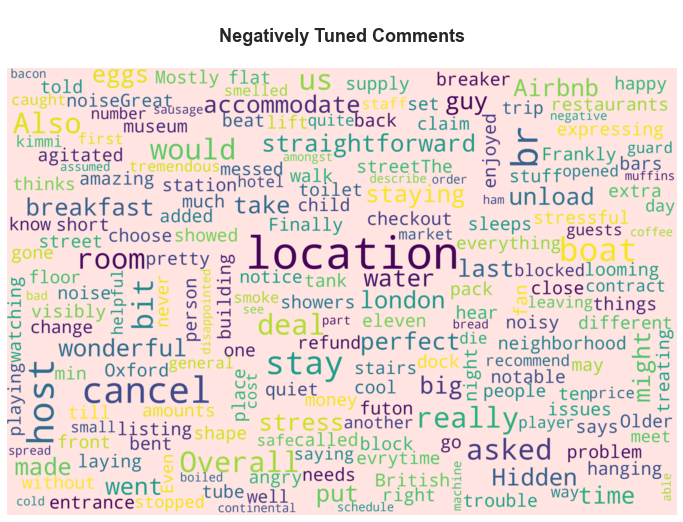

In [50]:
get_wordcloud_neighbourhood_neg("Westminster")

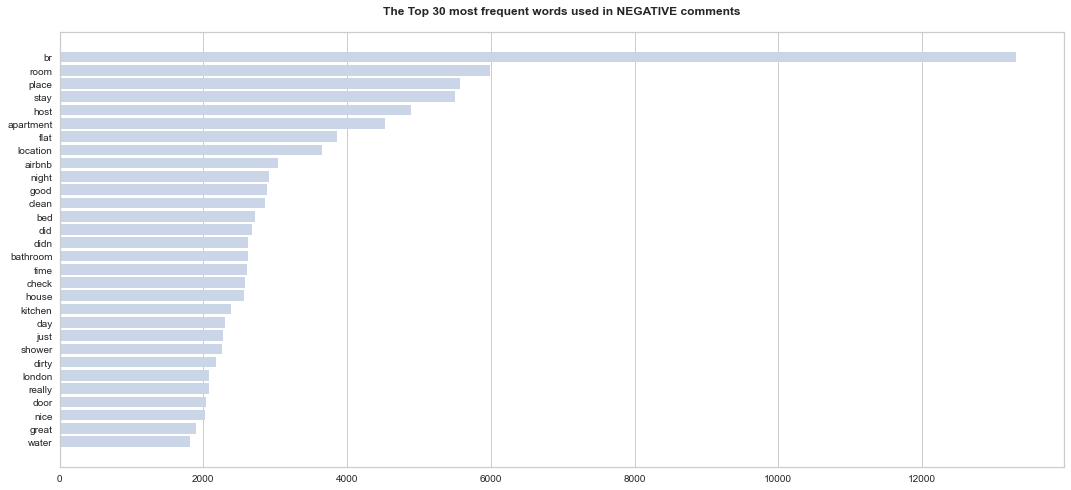

In [51]:
get_frequency_neg("Westminster")